# IHLT Lab 3

Lab developed by:
- Oriol Miró López-Feliu
- Niklas Long Schiefelbein


**Exercice description:**
1. Read all pairs of sentences of the SMTeuroparl files of test set within the evaluation framework of the project.
2. Compute their similarities by considering lemmas and Jaccard distance.
3. Compare the results with those in session 2 (document structure) in which words were considered.
4. Compare the results with gold standard by giving the pearson correlation between them.
5. Questions (justify the answers):
  - Which is better: words or lemmas?
  - Do you think that could perform better for any pair of texts?

## Imports

In [10]:
# base
import pandas as pd
import nltk

# distance
from nltk.metrics import jaccard_distance
from scipy.stats import pearsonr

# tokenizers
nltk.download('punkt')
from nltk.tokenize import word_tokenize

# cleaning
nltk.download('stopwords')
from string import punctuation

# LEMMAS!
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('omw-1.4')

# plotting
import matplotlib.pyplot as plt
import seaborn as sns

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


## Useful Functions

In [11]:
def compute_pearson_correlation(dt, column_name):
    return pearsonr(dt['gs'], dt[column_name])[0]

def plot_pearson_comparison(correlations, labels):

    # color palette (so we dont have to provide it, as variable nº of inputs)
    colors = sns.color_palette(n_colors=len(labels))

    # plot bar graph
    plt.figure(figsize=(8, 6))
    bars = plt.bar(labels, correlations, color=colors)

    plt.ylabel("Pearson's Correlation")
    plt.title("Comparison of Pearson's Correlation for Different Methods")
    plt.ylim(0, 1)  # Adjust the range based on your data

    # number above each bar (clarity)
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2, yval, round(yval, 3), ha='center', va='bottom')

    # show plot
    plt.show()

def print_sentences_diff(df, title):
    print(title)
    for index, row in df.iterrows():
        print(f"Sentence 1: {row[0]}")
        print(f"lemmatized sentence 1: {row['s0_lemmatized_nltk']}")
        print(f"Sentence 2: {row[1]}")
        print(f"lemmatized sentence 2: {row['s1_lemmatized_nltk']}")
        print(f"Difference (diff): {row['diff_performance']}\n")


wnl = nltk.stem.WordNetLemmatizer()
def lemmatize(p):
  d = {'NN': 'n', 'NNS': 'n',
       'JJ': 'a', 'JJR': 'a', 'JJS': 'a',
       'VB': 'v', 'VBD': 'v', 'VBG': 'v', 'VBN': 'v', 'VBP': 'v', 'VBZ': 'v',
       'RB': 'r', 'RBR': 'r', 'RBS': 'r'}
  if p[1] in d:
    return wnl.lemmatize(p[0], pos=d[p[1]])
  return p[0]


def lemmatize_sentence(tokens):
    # Get POS tags
    pos_tags = nltk.pos_tag(tokens)

    # Lemmatize using POS tag
    lemmatized_tokens = [lemmatize(pair) for pair in pos_tags]

    return lemmatized_tokens

## Data Loading

In [12]:
# mount google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [13]:
# load base data
dt = pd.read_csv('/content/drive/MyDrive/MAI_IHLT_LAB/data/test-gold/STS.input.SMTeuroparl.txt',sep='\t',header=None)

# include the gs labels
dt['gs'] = pd.read_csv('/content/drive/MyDrive/MAI_IHLT_LAB/data/test-gold/STS.gs.SMTeuroparl.txt',sep='\t',header=None)

In [14]:
# preprocessing
dt.drop_duplicates(inplace=True) # as we found out last session that there are 142 duplicates!

## Experiments

### Last labs results

In [15]:
# Here we compute JD's as last lab.
# PD: there is a note-worthy change: last session we found tokenising naively worked better, yet because lemmatization uses nltk's tokenizer,
#   to make results comparable we must also tokenize with nltk. Therefore we assume all results from lab2 hold when changing the tokenizer.

# what we do is:
# - tokenise with nltk
# - lowercase
# - remove stop words
# - remove punctuation

# ------------------------------------------------------- #

stop_words = set(nltk.corpus.stopwords.words('english'))

dt['jd_no_lemmatized'] = dt.apply(
    lambda row: (1 - jaccard_distance(
        set([word.lower() for word in word_tokenize(row[0]) if word.lower() not in stop_words and word not in punctuation]),
        set([word.lower() for word in word_tokenize(row[1]) if word.lower() not in stop_words and word not in punctuation])
    )) * 5, axis=1
)

# just to make sure, we recalculate pearson correlation (naive tokenizer yielded 0.391, nltk should give 0.379)
pearson_original = compute_pearson_correlation(dt, 'jd_no_lemmatized')
print(f"pearson correlation of last session: {pearson_original:.3f}")

pearson correlation of last session: 0.379


### NLTK Lemmatization

Considering our previous preprocessing removed potentially useful information for POS tagging (stopwords, ...), we must lemmatize first and then perform preprocessing

In [16]:
# tokenize
dt['s0_tokens'] = dt.apply(lambda row: word_tokenize(row[0]), axis=1)
dt['s1_tokens'] = dt.apply(lambda row: word_tokenize(row[1]), axis=1)

# lemmatize
dt['s0_lemmatized_nltk'] = dt['s0_tokens'].apply(lemmatize_sentence)
dt['s1_lemmatized_nltk'] = dt['s1_tokens'].apply(lemmatize_sentence)

# calculate jaccard + preprocessing (lowercase, remove stopwords, remove punctuation)
dt['jd_lemmatized'] = dt.apply(
    lambda row: (1 - jaccard_distance(
        set([word.lower() for word in row['s0_lemmatized_nltk'] if word.lower() not in stop_words and word not in punctuation]),
        set([word.lower() for word in row['s1_lemmatized_nltk'] if word.lower() not in stop_words and word not in punctuation])
    )) * 5, axis=1
)

pearson_lemmatisation = compute_pearson_correlation(dt, 'jd_lemmatized')

## Results

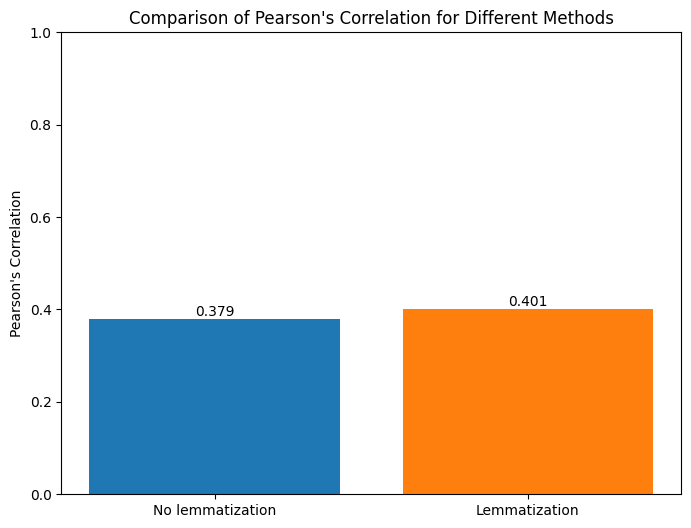

In [17]:
plot_pearson_comparison([pearson_original, pearson_lemmatisation], ['No lemmatization', 'Lemmatization'])

- **Which is better: words or lemmas?:**
  The pearson correlations suggest that lemmas work better than words, probably because they account for morphological variations. Even then, lemmas are limited as they can not capture, for example, synonyms.

- **Do you think that could perform better for any pair of texts?:**
  No. Lemmatization could result in loss of important information, such as time (past vs present), number (plural vs singular), etc.. In cases where this plays an important role in a sentence's meaning, the semantics, it might be better to not lemmatize.

  Example: consider two sentences, s0 and s1
    - s0 = "I hated cats, but love them now"
    - s1 = "I hate cats and always will"
  s0 and s1 have very different meanings, yet if we lemmatized them, "hated" becomes "hate", causing an important loss of information to the sentence meaning - making both sentences appear similar despite that not being true.


Furthermore, we compute cases where words performed better than lemmas:

In [18]:
# cases where no lemmatisation worked better
# to find more illustrative examples, we find cases where the difference in performance was greater
dt['diff_no_lemmatized'] = (dt['jd_no_lemmatized'] - dt['gs']).abs()
dt['diff_lemmatized'] = (dt['jd_lemmatized'] - dt['gs']).abs()

filtered_cases = dt[dt['diff_no_lemmatized'] < dt['diff_lemmatized']]
print(f"no lemmatisation performed better in {len(filtered_cases)} cases ({len(filtered_cases)/len(dt):.2f}% of total)\n\n")

# => the smaller each value is, the better (less difference w.r.t. 'gs')
#   and we want the cases where no lemmatisation performed (much) better than lemmatisation
#   => diff_lemmatized - diff_no_lemmatized should be large!
filtered_cases['diff_performance'] = (filtered_cases['diff_lemmatized'] - filtered_cases['diff_no_lemmatized'])
sorted_cases = filtered_cases.sort_values(by='diff_performance', ascending=False)

print_sentences_diff(sorted_cases[:5], "Sentences where the difference in performance was greater")

no lemmatisation performed better in 18 cases (0.06% of total)


Sentences where the difference in performance was greater
Sentence 1: The fishermen are inactive, tired and disappointed.
lemmatized sentence 1: ['The', 'fisherman', 'be', 'inactive', ',', 'tired', 'and', 'disappointed', '.']
Sentence 2: The fishermen inactive, are tired and disappointed.
lemmatized sentence 2: ['The', 'fisherman', 'inactive', ',', 'be', 'tire', 'and', 'disappoint', '.']
Difference (diff): 3.333333333333333

Sentence 1: Amendment No 7 proposes certain changes in the references to paragraphs.
lemmatized sentence 1: ['Amendment', 'No', '7', 'propose', 'certain', 'change', 'in', 'the', 'reference', 'to', 'paragraph', '.']
Sentence 2: Amendment No 7 proposes changes to certain paragraphs references.
lemmatized sentence 2: ['Amendment', 'No', '7', 'proposes', 'change', 'to', 'certain', 'paragraphs', 'reference', '.']
Difference (diff): 2.2222222222222223

Sentence 1: The fishermen are inactive, tired and disap

<ipython-input-18-4b28e8d8d60c>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_cases['diff_performance'] = (filtered_cases['diff_lemmatized'] - filtered_cases['diff_no_lemmatized'])


Interestingly the words are sometimes lemmatized in a different manner, depending on the context (see the first example, the same word "tired" gets lemmatized to both "tire" and "tired"); this is likely due to POS or lemmatizer errors, and would require further investigation to ameliorate.